In [2]:
#pip install mlflow==1.10.0

AttributeError: module 'mlflow' has no attribute '__versoin__'

## Setup Environment <br>

Python 3.8 <br>
Numpy: 1.23.0 <br>
Pandas: 1.5.3 <br>
matplotlib: 3.7.1 <br>
seaborn: 0.10.1 <br>
Scikit-Learn: 1.1.3 <br>
MLFlow: 1.30.0 <br>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold 
import mlflow
import mlflow.sklearn


In [2]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.23.0
Pandas: 1.5.3
matplotlib: 3.7.1
seaborn: 0.10.1
Scikit-Learn: 1.1.3
MLFlow: 1.30.0


### Load the Data

In [3]:
data_path = "../creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)
# remove time column since it was found that it is not helpful

In [5]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preparation

#### Split data to normal and anomaly

In [4]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True) 
anomaly = df[df.Class == 1]

In [ ]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


#### Split into train/ dev/ test sets

In [5]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)


#### Concatenate set to creates X-Y sets

In [6]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate,anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)


In [9]:
print("Training sets:\nx_train: {} \ny_train:{}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train:(85588,)

Testing sets:
x_test: (28531, 29) 
y_test:(28531,)

Validation sets:
x_validate: (28531, 29) 
y_validate: (28531,)


#### Scale the data

In [7]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## Train and Evaluate

Train function

In [8]:
def train(sk_model, x_train, y_train): 
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

Evaluate function

In [10]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    # ask MLFlow to log two more metrics
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = plot_roc_curve(sk_model, x_test, y_test,name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()

    conf_matrix = confusion_matrix(y_test, preds)
 
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix") 
    plt.savefig("sklearn_conf_matrix.png")
    # save the plots generated by matplotlib and by seaborn.
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

## Log and View MLFlow Runs

In [11]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg')

Traceback (most recent call last):
  File "/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 271, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 405, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 1101, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 1094, in _read_helper
    result = read_yaml(root, file_name)
  File "/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/mlflow/utils/file_utils.py", line 182, in read_yaml
    raise 

Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


/Users/alimokh/opt/miniconda3/envs/mlflow1/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


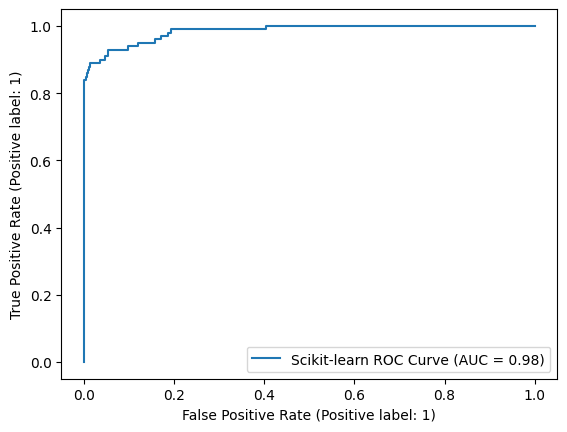

Model run:  7065332b8e204ec9a22ce77762092ee3


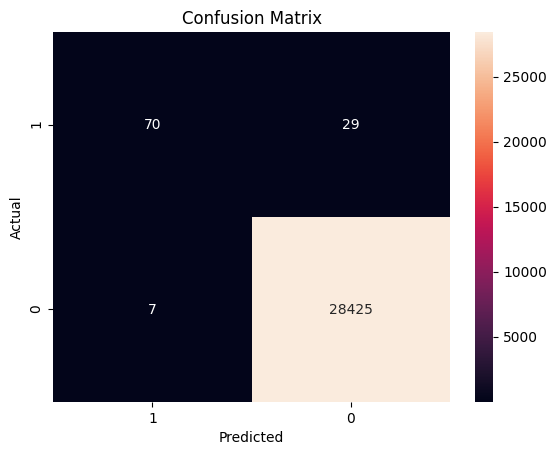

In [13]:
# puts the run under experiment name
mlflow.set_experiment("scikit_learn_experiment") 

# chunk all code under the context of one MLFlow run.
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    # save the model
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

On terminal, write: mlflow ui -p 1234
so you can access mlflow UI

and then go to 127.0.0.1:1234

## Loading a Logged Model

In [39]:
loaded_model = mlflow.sklearn.load_model("runs:/34be0913c3c8467a9061eb47b67628a5/log_reg_model")

In [40]:
loaded_model.score(x_test, y_test)

0.9987382145736217

In [16]:
x_test

array([[-1.17362921,  1.31797632, -0.73359473, ...,  1.20727226,
         0.99802045, -0.32742236],
       [-0.39215527,  0.6299131 ,  0.79925401, ..., -0.06476623,
         0.15898721, -0.33791875],
       [ 0.01896693, -0.38831066,  0.30187387, ...,  0.44082095,
         0.40919241, -0.18358291],
       ...,
       [ 0.94148201,  0.64426556, -1.11897491, ...,  0.10419496,
         0.1215325 , -0.34297257],
       [-0.76080487,  0.6827188 , -1.00780021, ...,  1.01108636,
         0.81108554,  0.88980931],
       [-5.20609906,  3.92012265, -9.5660635 , ..., -1.1412922 ,
         0.32030633, -0.34297257]])

## MLFlow Parameter Tuning

### Broad Search

In [41]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [45]:
mlflow.set_experiment("sklearn_creditcard_broad_search") 
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f] 
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {0: 1,1: weight }
            sk_model = LogisticRegression(random_state=None, max_iter=400,
                                        solver='newton-cg',
                                        class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="") 
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],
            y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model,
            f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8406451922461774
eval_acc: 0.9982474588152822
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages: 
Accuracy:  0.9985980161860246
AUC:  0.8437245395411569
Best: 
Accuracy:  0.9989484752891693
AUC:  0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.975398919462244
eval_acc: 0.9982474588152822
----------------------------------------
fold 3
Anomaly

### Guided Search

In [46]:
anomaly_weights = [10, 50, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

Create a new experiment for this

In [47]:
mlflow.set_experiment("sklearn_creditcard_Guided_search") 
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f] 
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {0: 1,1: weight }
            sk_model = LogisticRegression(random_state=None, max_iter=400,
                                        solver='newton-cg',
                                        class_weight=class_weights).fit(x_validate[train],y_validate[train])
            for h in range(40): print('-', end="") 
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,
            eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test],
            y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model,
            f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

INFO: 'sklearn_creditcard_Guided_search' does not exist. Creating a new experiment
----------------------------------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
----------------------------------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
----------------------------------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
----------------------------------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257

Averages: 
Accuracy:  0.9984227743510024
AUC:  0.9214920858175297
Best: 
Accuracy:  0.9985979670522257
AUC:  0.9753109687146626
----------------------------------------
fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval_acc: 0.9947432977045734
----------------------------------------
fold 2
Anomaly Weight: 50
AU